In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 4.4 MB 7.3 MB/s 
     |████████████████████████████████| 1.2 MB 56.3 MB/s 
     |████████████████████████████████| 101 kB 14.7 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 6.6 MB 46.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=eb835d1f0a1f4e5ed5f90c666923c46745599a68ba0a637a46a032b49d220b7e
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from scipy.sparse.csr import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_licitaciones_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
0,32500000,32000000,32500000.0,NaN,NaN,Adquisición de repuestos para el ILS AMS 2100,adquisición repuesto
1,65310000,65000000,65300000.0,65310000.0,NaN,Suministro de energía eléctrica en el Centro d...,suministrar energía eléctrico centrar conserva...
2,92112000,92000000,92100000.0,92110000.0,92112000.0,"Servicio de duplicado de copias de películas, ...",servicio duplicar copiar película tráiler vide...
3,9122110,9000000,9100000.0,9120000.0,9122000.0,Gas Licuado Propano 2013/2014,licuar propano
4,75000000,75000000,NaN,NaN,NaN,Servicio de vigilancia del Centro Cultural de ...,servicio vigilancia centrar cultural españa mé...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387194 entries, 0 to 387193
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_cpv        387194 non-null  int64  
 1   id_division   387194 non-null  int64  
 2   id_grupo      344341 non-null  float64
 3   id_clase      282283 non-null  float64
 4   id_categoria  193738 non-null  float64
 5   objeto        387194 non-null  object 
 6   clean_text    387194 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 20.7+ MB


In [ ]:
df.isnull().sum()

id_cpv               0
id_division          0
id_grupo         42853
id_clase        104911
id_categoria    193456
objeto               0
clean_text           0
dtype: int64

In [ ]:
#Vemos aquellos registros que al preprocesar la descripción se vuelve nulo
df[df['clean_text'].isnull()]

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text


In [7]:
df = df.sample(n=100000, random_state=1)
df

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
222929,90481000,90000000,90400000.0,90480000.0,90481000.0,Servicio de funcionamiento y mantenimiento del...,servicio funcionamiento mantenimiento sistema ...
64942,55000000,55000000,NaN,NaN,NaN,46/VC-0055/16 Explotación del servicio de la c...,explotación servicio ubicar sedar central dire...
131625,45233251,45000000,45200000.0,45230000.0,45233000.0,Repavimentación Parque,repavimentación parque
72369,38433000,38000000,38400000.0,38430000.0,38433000.0,Suministro e instalación del fluorímetro. Cofi...,suministrar instalación fluorímetro cofinancia...
171521,71520000,71000000,71500000.0,71520000.0,NaN,"Vigilancia de obra, realización de ensayos com...",vigilancia obrar realización ensayo complement...
...,...,...,...,...,...,...,...
332904,45212220,45000000,45200000.0,45210000.0,45212000.0,Reforma y Mejora del Polideportivo Pisuerga y ...,reformar mejorar polideportivo pisuerga área j...
186628,45231300,45000000,45200000.0,45230000.0,45231000.0,CASTILLEJO DEL ROMERAL.-Renovación de redes y ...,castillejo redar mejorar eficiencia ciclar hid...
283311,34631000,34000000,34600000.0,34630000.0,34631000.0,.suministro de repuestos man 2021-09,repuesto
361386,33141000,33000000,33100000.0,33140000.0,33141000.0,Suministro de cartuchos para la determinación ...,suministrar cartucho determinación tiempo coag...


In [ ]:
df.groupby(['id_division']).count()['objeto']

id_division
3000000      3209
9000000      7625
14000000     1009
15000000     4085
16000000      572
18000000     3762
19000000      526
22000000     2710
24000000     2344
30000000     9438
31000000     5062
32000000     3944
33000000    20280
34000000    17050
35000000     5019
37000000     1466
38000000     6610
39000000     6629
41000000      151
42000000     5445
43000000      750
44000000     8228
45000000    65265
48000000     8038
50000000    29686
51000000      897
55000000     9723
60000000     8086
63000000     3208
64000000     3330
65000000      627
66000000     6733
70000000     3343
71000000    20358
72000000    19244
73000000     2101
75000000     1586
76000000       39
77000000     3693
79000000    26186
80000000     6814
85000000    17495
90000000    15482
92000000    14354
98000000     4992
Name: objeto, dtype: int64

In [8]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_division'] # Labels

In [9]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/1000000.0)))

In [10]:
#sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
#sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
sbert_model = SentenceTransformer("PlanTL-GOB-ES/roberta-base-bne")

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/PlanTL-GOB-ES_roberta-base-bne. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/PlanTL-GOB-ES_roberta-base-bne were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from t

In [11]:
def get_sentence_embeding(sentences, sbert_model):
    return sbert_model.encode(sentences)

In [12]:
s = get_sentence_embeding([
    "TRABAJOS DE REHABILTACIÓN Y MANTTO",
    "ADQUISICION DE INSUMOS DE LISOSOMALES",
    "SERVICIO DE ARRENDAMIENTO INTEGRAL",
    "Materiales para mantenimiento de lámparas"
    ], sbert_model
)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([s[0]],[s[2]])

array([[0.95458317]], dtype=float32)

In [11]:
sentence_embeddings = sbert_model.encode(df['clean_text'].values[0:5])

In [14]:
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 768
Sample BERT embedding vector - note includes negative values [-3.64644006e-02  4.82396856e-02  7.86007196e-02 -5.76995537e-02
  1.27569526e-01  1.61229968e-01 -3.15786488e-02  9.82149690e-02
  4.81638312e-02  6.76378757e-02  8.75113904e-02 -1.48628885e-02
  2.71687359e-02  3.70199755e-02  1.64771959e-01  1.43281490e-01
  1.63467228e-01 -1.25427902e-01 -6.70921877e-02  5.94893172e-02
 -1.36086866e-01 -9.21395607e-03 -6.96150735e-02 -1.09152190e-01
  5.90859652e-02 -6.12478703e-04 -1.34774238e-01 -1.05905928e-01
 -5.58157489e-02 -4.91988249e-02 -8.89499858e-02 -1.09821603e-01
  7.34373853e-02 -1.83550343e-02  4.85301837e-02 -2.63211042e-01
 -1.26341153e-02 -4.31580748e-03 -3.80716622e-02 -8.80675167e-02
 -2.43339036e-02  4.53572348e-02  6.14311807e-02 -1.04239397e-02
  6.14934787e-02  2.63397535e-03 -5.05751610e+00  7.98940361e-02
 -2.76034832e-01 -1.44063700e-02 -1.11642748e-01  8.84439051e-03
 -6.66832104e-02 -4.32415865e-02  2.50548404e-02  5.

In [14]:
X = X.apply(lambda description: get_sentence_embeding(description, sbert_model))

In [15]:
#to sparse matrix
X_vect = csr_matrix(pd.DataFrame(np.vstack(X)))

In [16]:
X_vect

<100000x768 sparse matrix of type '<class 'numpy.float32'>'
	with 76800000 stored elements in Compressed Sparse Row format>

In [17]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X_vect, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
#X_train_vec = pd.DataFrame(np.vstack( X_train.apply(lambda description: get_sentence_embeding(description, sbert_model))))
#X_test_vec = pd.DataFrame(np.vstack( X_test.apply(lambda description: get_sentence_embeding(description, sbert_model))))

In [18]:
X_train.shape

(80000, 768)

In [19]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [20]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [21]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

##Escaler

In [22]:
from sklearn.preprocessing import StandardScaler 
#removes the mean and scales the data to unit variance. [-0.2, 0.2] range
scaler = StandardScaler(with_mean=False).fit(X_vect)
X_train_SS = scaler.transform(X_train)
X_test_SS = scaler.transform(X_test)

##MultinomialNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
parametersMNB = { 
                 'var_smoothing':[1e-9]
                }
modelMNB = GaussianNB()

In [ ]:
clf_MNB_GS = GridSearchCV(modelMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train_SS, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09]}, verbose=3)

In [ ]:
# Let's see the results
y_pred = clf_MNB_GS.predict(X_test_SS)

In [ ]:
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'var_smoothing': 1e-09}

Grid scores on testing set:

0.472 (+/-0.005) for {'var_smoothing': 1e-09}

best score:  0.4715312417556399

Grid times on testing set:

1.501 seconds (+/-1.208) for {'var_smoothing': 1e-09}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.4158087090096291, 'accuracy': 0.47285}
              precision    recall  f1-score   support

     3000000       0.52      0.54      0.53       334
     9000000       0.58      0.55      0.56       790
    14000000       0.09      0.38      0.15       108
    15000000       0.58      0.55      0.56       415
    16000000       0.22      0.57      0.32        65
    18000000       0.34      0.33      0.33       380
    19000000       0.03      0.39      0.05        57
    22000000       0.19      0.55      0.29       279
    24000000       0.12      0.37  

<Figure size 432x288 with 0 Axes>

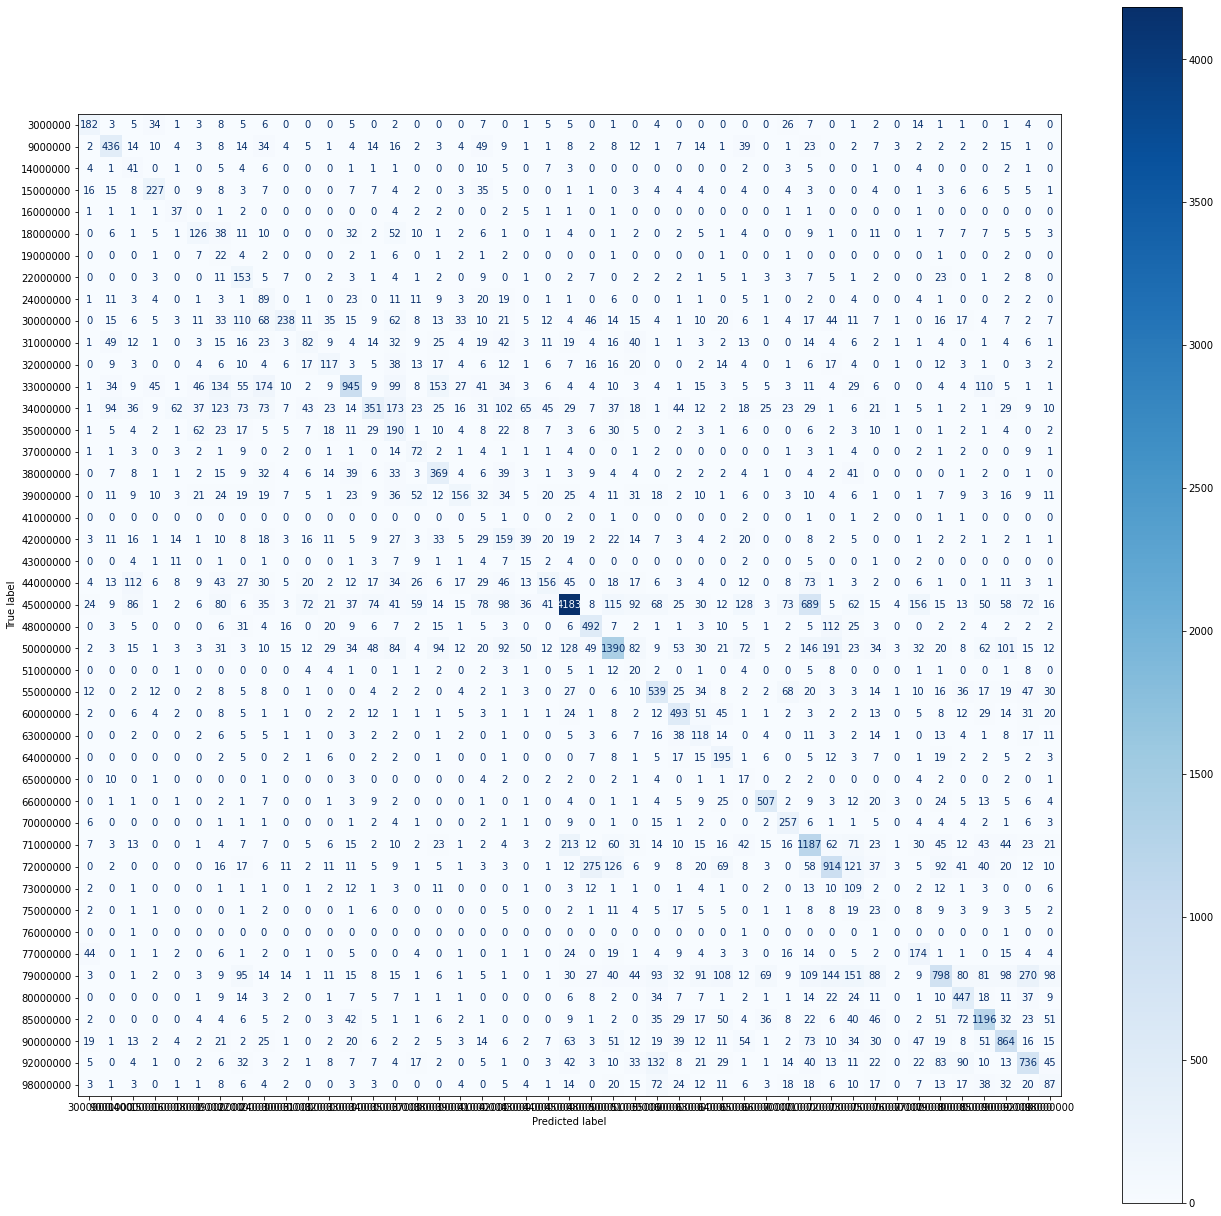

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##LinearSVM

In [ ]:
#For large datasets consider using LinearSVC = SGDClassifier with loss hinge and penalty l2
parametersSVM = { 
                 'max_iter':[100, 500, 1000, 1500]
                 }
modelSVM = SGDClassifier(loss='hinge', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [ ]:
#Model and hyperparameters
clf_GS_SVM = GridSearchCV(modelSVM, parametersSVM, cv=2, n_jobs=-1, verbose=10)
clf_GS_SVM.fit(X_train_SS, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 184.15, NNZs: 768, Bias: -8.137401, T: 144000, Avg. loss: 33.547135
Total training time: 0.30 seconds.
Norm: 220.88, NNZs: 768, Bias: -9.151917, T: 144000, Avg. loss: 46.004475
Total training time: 0.28 seconds.
-- Epoch 2
-- Epoch 2
Norm: 116.32, NNZs: 768, Bias: -8.191866, T: 288000, Avg. loss: 3.098506
Total training time: 0.92 seconds.
Norm: 144.63, NNZs: 768, Bias: -9.137715, T: 288000, Avg. loss: 3.873652
Total training time: 0.88 seconds.
-- Epoch 3
-- Epoch 3
Norm: 91.23, NNZs: 768, Bias: -8.191624, T: 432000, Avg. loss: 1.726193
Total training time: 1.52 seconds.
Norm: 112.39, NNZs: 768, Bias: -9.164085, T: 432000, Avg. loss: 2.182944
Total training time: 1.50 seconds.
-- Epoch 4
-- Epoch 4
Norm: 76.72, NNZs: 768, Bias: -8.206617, T: 576000, Avg. loss: 1.175282
Total training time: 2.14 seconds.
Norm: 93.93, NNZs: 768, Bias: -9.164659, T: 576000, Avg. loss: 1.479526
Total training time: 2.04 seconds.
-- Epoch 5
-- Epoch 5
Norm: 67.28, NNZs: 768, Bia

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


-- Epoch 1
-- Epoch 6
Norm: 225.26, NNZs: 768, Bias: -12.008337, T: 144000, Avg. loss: 47.129965
Total training time: 0.26 seconds.
Norm: 960.87, NNZs: 768, Bias: -32.626918, T: 864000, Avg. loss: 46.649374
Total training time: 3.40 seconds.
-- Epoch 2
Convergence after 6 epochs took 3.75 seconds
-- Epoch 1
Norm: 147.59, NNZs: 768, Bias: -12.005758, T: 288000, Avg. loss: 4.644753
Total training time: 0.93 seconds.
-- Epoch 3
Norm: 109.85, NNZs: 768, Bias: -6.175177, T: 144000, Avg. loss: 91.522314
Total training time: 0.37 seconds.
-- Epoch 2
Norm: 116.15, NNZs: 768, Bias: -11.969883, T: 432000, Avg. loss: 2.696959
Total training time: 1.59 seconds.
-- Epoch 4
Norm: 71.21, NNZs: 768, Bias: -6.204474, T: 288000, Avg. loss: 11.482329
Total training time: 1.00 seconds.
-- Epoch 3
Norm: 97.85, NNZs: 768, Bias: -11.957305, T: 576000, Avg. loss: 1.784951
Total training time: 2.22 seconds.
-- Epoch 5
Norm: 55.57, NNZs: 768, Bias: -6.193190, T: 432000, Avg. loss: 6.655940
Total training time: 

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, n_jobs=-1,
                                     random_state=42, verbose=2),
             n_jobs=-1, param_grid={'max_iter': [100, 500, 1000, 1500]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SVM.predict(X_test_SS)
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'max_iter': 100}

Grid scores on testing set:

0.415 (+/-0.099) for {'max_iter': 100}
0.415 (+/-0.099) for {'max_iter': 500}
0.415 (+/-0.099) for {'max_iter': 1000}
0.415 (+/-0.099) for {'max_iter': 1500}

best score:  0.4150375

Grid times on testing set:

98.277 seconds (+/-1.036) for {'max_iter': 100}
85.534 seconds (+/-0.184) for {'max_iter': 500}
77.427 seconds (+/-1.778) for {'max_iter': 1000}
76.981 seconds (+/-0.732) for {'max_iter': 1500}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.36493517985369806, 'accuracy': 0.386225}
              precision    recall  f1-score   support

     3000000       0.83      0.40      0.54       334
     9000000       0.93      0.28      0.43       790
    14000000       0.42      0.21      0.28       108
    15000000       0.83      0.51      0.63       415
    16000000 

<Figure size 432x288 with 0 Axes>

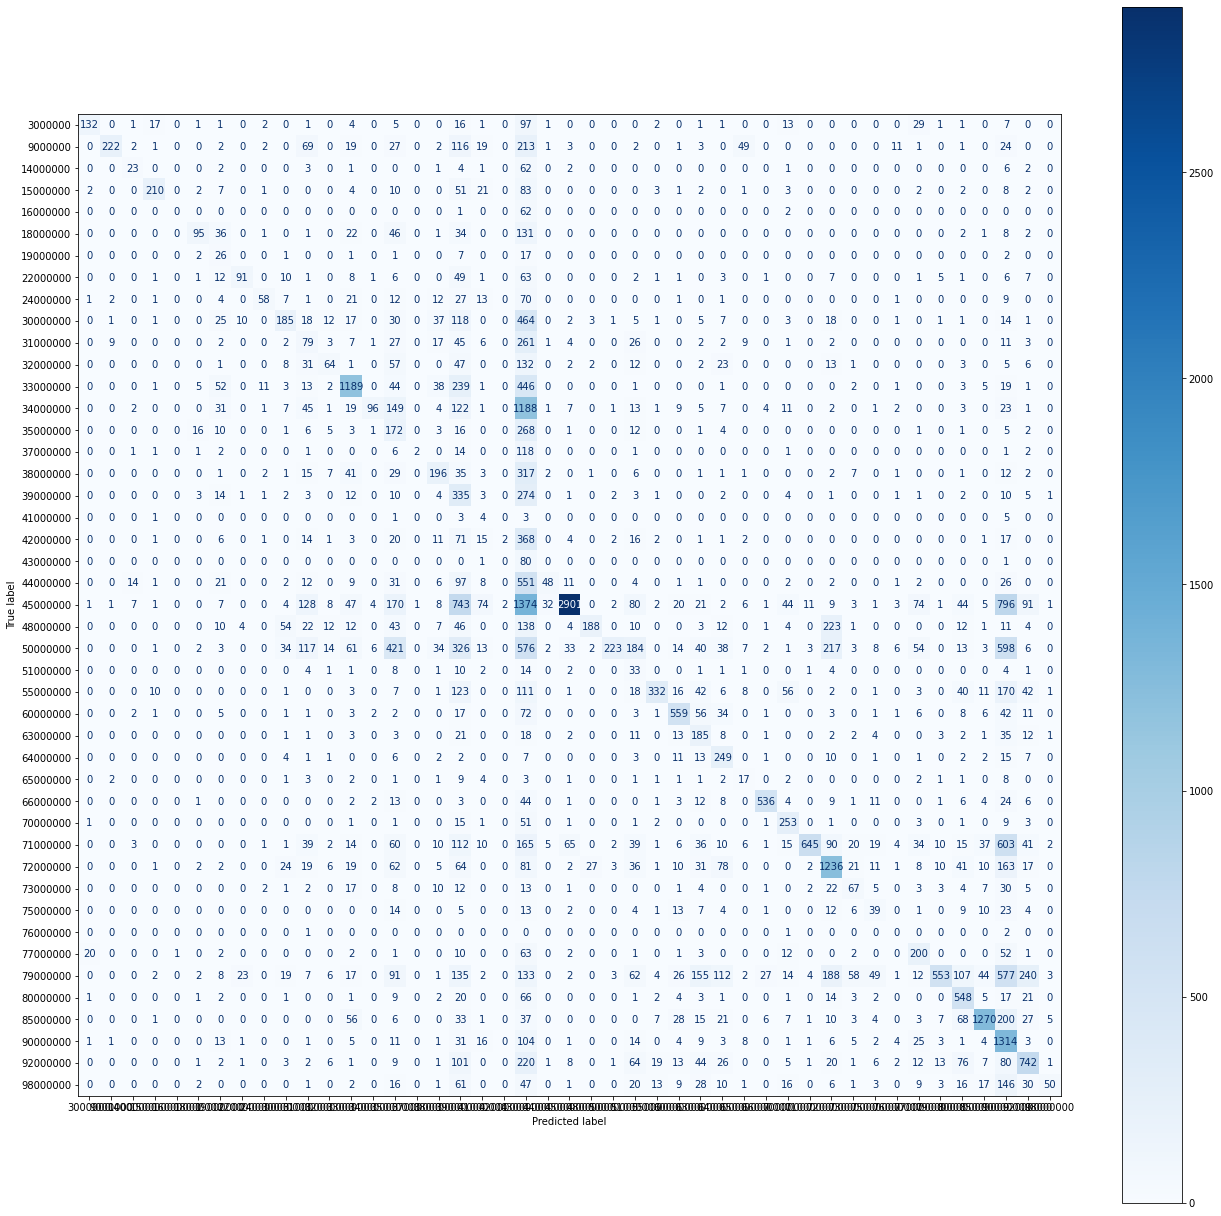

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##SGDClassifier

In [23]:
#Model and hyperparameters
parametersSGD = { 
                 'max_iter':[200, 300, 500],
                 'loss':['modified_huber', 'squared_hinge', 'perceptron']
                 }
modelSGD = SGDClassifier(loss='perceptron', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [24]:
#Model and hyperparameters
clf_GS_SGD = GridSearchCV(modelSGD, parametersSGD, cv=2, n_jobs=-1, verbose=10)
clf_GS_SGD.fit(X_train_SS, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 361713273227718.38, NNZs: 768, Bias: -73340429499.613281, T: 72000, Avg. loss: 2638832132076088014503829045248.000000
Total training time: 0.20 seconds.
Norm: 740257103494824.00, NNZs: 768, Bias: -83722000895.943375, T: 72000, Avg. loss: 24415699499481467039798276390912.000000
Total training time: 0.18 seconds.
-- Epoch 2
-- Epoch 2
Norm: 234459036974902.34, NNZs: 768, Bias: -74253094589.342087, T: 144000, Avg. loss: 7888771536926610105284165632.000000
Total training time: 0.58 seconds.
Norm: 496594892461296.25, NNZs: 768, Bias: -86414316815.737686, T: 144000, Avg. loss: 60568584605144872227394551808.000000
Total training time: 0.55 seconds.
-- Epoch 3
-- Epoch 3
Norm: 183548698077210.12, NNZs: 768, Bias: -74821351792.302032, T: 216000, Avg. loss: 2546531380485045274921664512.000000
Total training time: 0.96 seconds.
Norm: 394915096378374.44, NNZs: 768, Bias: -86024445879.790604, T: 216000, Avg. loss: 18777713799316467662433812480.000000
Total training time:

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.1s


Norm: 126043723791260.00, NNZs: 768, Bias: -88832579596.537399, T: 432000, Avg. loss: 711468876159208639764103168.000000
Total training time: 2.10 seconds.
-- Epoch 1
Convergence after 6 epochs took 2.28 seconds
Norm: 167745631422102.50, NNZs: 768, Bias: -57807089899.727821, T: 72000, Avg. loss: 2422712081316838594766369193984.000000
Total training time: 0.20 seconds.
-- Epoch 1
-- Epoch 2
Norm: 261129737962323.56, NNZs: 768, Bias: -67203322221.994629, T: 72000, Avg. loss: 1131526124692430614047796232192.000000
Total training time: 0.17 seconds.
Norm: 110384746784055.77, NNZs: 768, Bias: -57858253213.250046, T: 144000, Avg. loss: 15305667605194081617638850560.000000
Total training time: 0.63 seconds.
-- Epoch 2
-- Epoch 3
Norm: 175818587607747.25, NNZs: 768, Bias: -67960449887.034622, T: 144000, Avg. loss: 6607386908445531536562847744.000000
Total training time: 0.55 seconds.
Norm: 88273614380588.11, NNZs: 768, Bias: -57441679064.166206, T: 216000, Avg. loss: 49913456877529228977226383

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   57.9s finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, loss='perceptron',
                                     n_jobs=-1, random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'loss': ['modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': [200, 300, 500]},
             verbose=10)

In [25]:
# Let's see the results
y_pred = clf_GS_SGD.predict(X_test_SS)
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'squared_hinge', 'max_iter': 200}

Grid scores on testing set:

0.326 (+/-0.323) for {'loss': 'modified_huber', 'max_iter': 200}
0.326 (+/-0.323) for {'loss': 'modified_huber', 'max_iter': 300}
0.326 (+/-0.323) for {'loss': 'modified_huber', 'max_iter': 500}
0.455 (+/-0.090) for {'loss': 'squared_hinge', 'max_iter': 200}
0.455 (+/-0.090) for {'loss': 'squared_hinge', 'max_iter': 300}
0.455 (+/-0.090) for {'loss': 'squared_hinge', 'max_iter': 500}
0.286 (+/-0.250) for {'loss': 'perceptron', 'max_iter': 200}
0.286 (+/-0.250) for {'loss': 'perceptron', 'max_iter': 300}
0.286 (+/-0.250) for {'loss': 'perceptron', 'max_iter': 500}

best score:  0.4554125

Grid times on testing set:

56.390 seconds (+/-0.259) for {'loss': 'modified_huber', 'max_iter': 200}
54.890 seconds (+/-0.491) for {'loss': 'modified_huber', 'max_iter': 300}
63.246 seconds (+/-0.774) for {'loss': 'modified_huber', 'max_iter': 500}
55.028 seconds (+/-0

<Figure size 432x288 with 0 Axes>

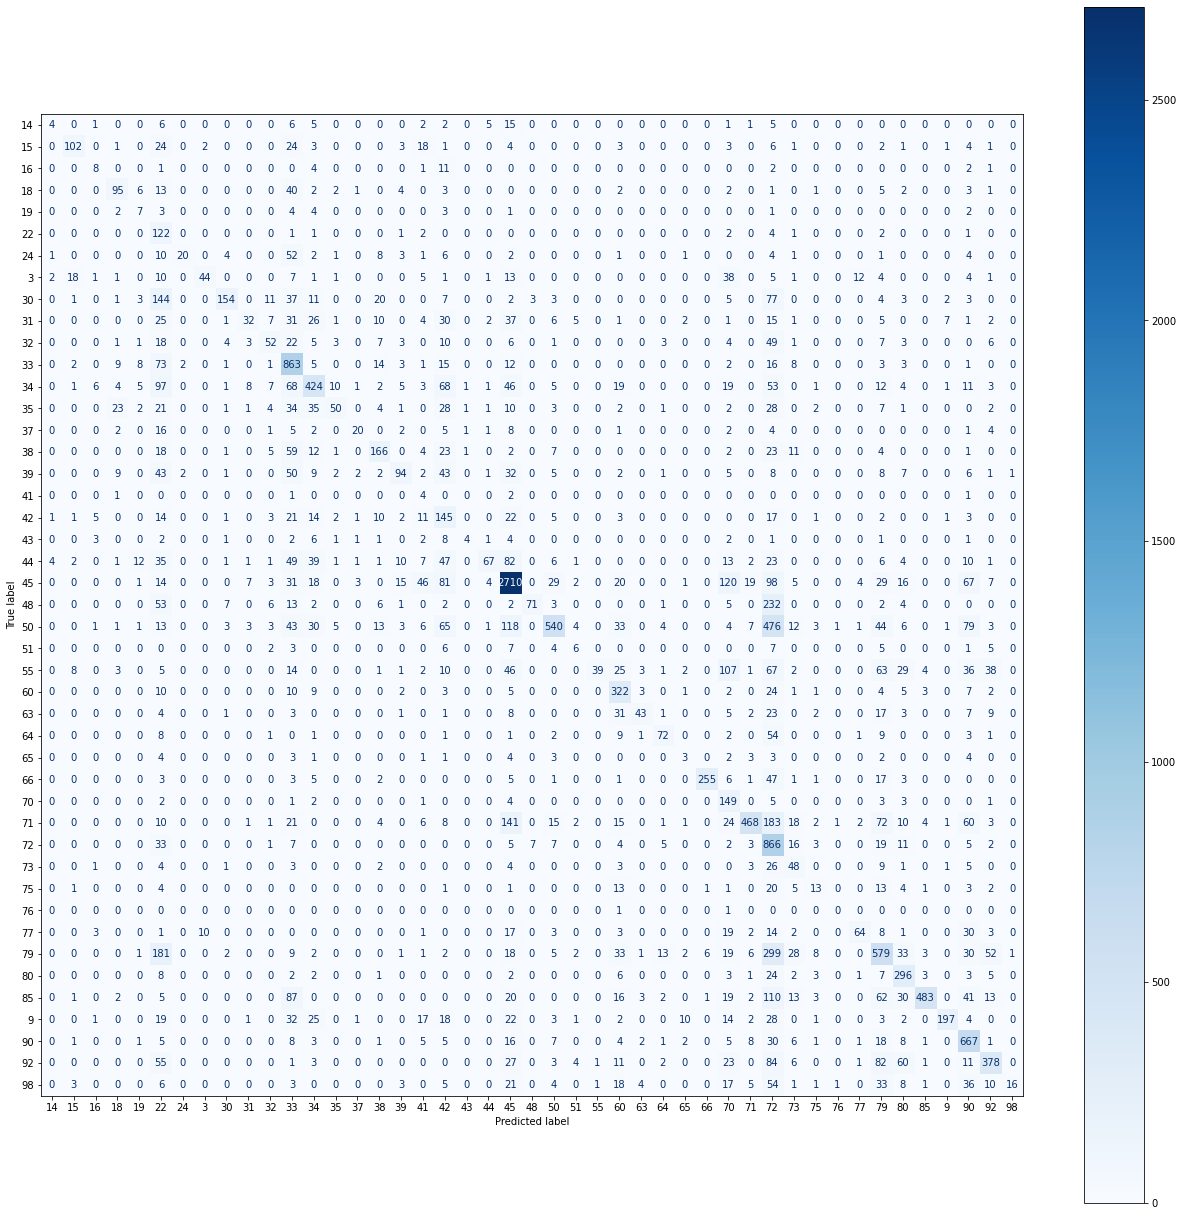

In [26]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##Otras pruebas

In [ ]:
# Classify algoritmo SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, random_state=0, probability=True)
# Entrenamiento del algoritmo 
SVM.fit(X_train_vec, y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [ ]:
#For large datasets consider using LinearSVC
model = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

NameError: ignored

In [ ]:
# Entrenamiento del algoritmo 
model.fit(X_train_vec, y_train)

NameError: ignored

In [ ]:
# Let's see the results
y_pred = SVM.predict(X_test_vec)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.92      0.94      0.93      4307
        3000       0.91      0.92      0.92      4298
        5000       0.81      0.32      0.46       284
        6000       0.90      0.90      0.90      1111

    accuracy                           0.91     10000
   macro avg       0.88      0.77      0.80     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = sbert_model.encode(df['descripcion'].values)
examples

In [ ]:
 #Prediction
test = model.predict(examples)
test

Accuracy del modelo ->  91.07
Porcentaje de acierto para cada una de las clases: 
              precision    recall  f1-score   support

        2000       0.92      0.94      0.93      4307
        3000       0.91      0.92      0.92      4298
        5000       0.81      0.32      0.46       284
        6000       0.90      0.90      0.90      1111

    accuracy                           0.91     10000
   macro avg       0.88      0.77      0.80     10000
weighted avg       0.91      0.91      0.91     10000

Matriz de confusion test: 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

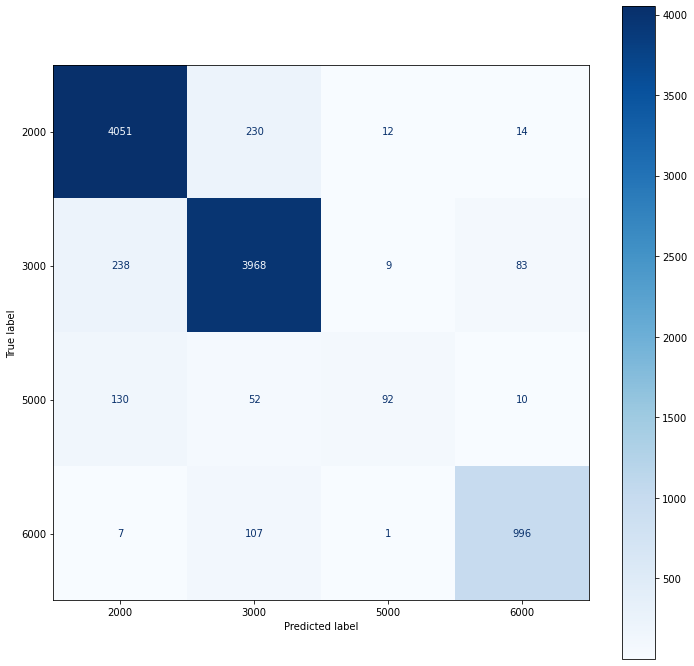

Matriz de confusion train: 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

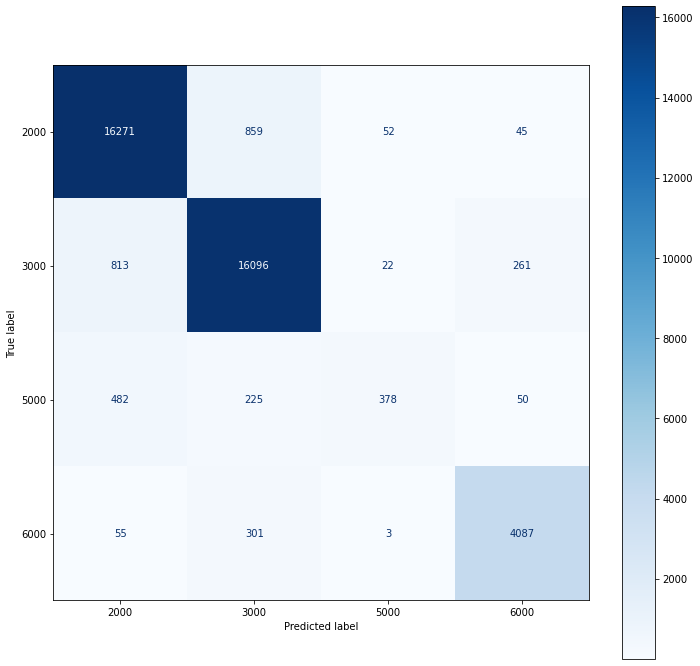

In [ ]:
# Evaluacion del modelo 
print("Accuracy del modelo -> ",metrics.accuracy_score(y_pred, y_test)*100)

print("Porcentaje de acierto para cada una de las clases: ")
print(metrics.classification_report(y_test, y_pred))

print("Matriz de confusion test: ")
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(SVM, X_test_vec, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

print("Matriz de confusion train: ")
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(SVM, X_train_vec, y_train, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 


In [ ]:
# Finally, let's try the examples again:
test = clf.predict(["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"])
test

array([2000, 2000, 3000, 2000, 2000, 2000])

In [ ]:
dfsample.groupby(['id_concepto']).count()

,id_capitulo,id_partida_generica,descripcion,clean_text
id_concepto,,,,
2100,807,807,807,807
2200,399,399,399,399
2300,4454,4454,4454,4454
2400,385,385,385,385
2500,3809,3809,3809,3809
2600,250,250,250,250
2700,298,298,298,298
2800,24,24,24,24
2900,443,443,443,443


In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = dfsample['clean_text'] # Text
Y = dfsample['id_concepto'] # Labels

In [ ]:
# Classify
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
clfConcepto = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('linearsvc', LinearSVC(random_state=42))
])
clfConcepto.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(random_state=42))])

In [ ]:
# Let's see the results
y_pred = clfConcepto.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2100       0.81      0.73      0.77       167
        2200       0.78      0.74      0.76        82
        2300       0.96      0.95      0.95       840
        2400       0.53      0.44      0.48        70
        2500       0.82      0.92      0.86       795
        2600       0.87      0.83      0.85        58
        2700       0.83      0.69      0.75        64
        2800       0.00      0.00      0.00         5
        2900       0.69      0.52      0.59        85
        3100       0.68      0.45      0.54       115
        3200       0.70      0.70      0.70        81
        3300       0.84      0.90      0.87      1211
        3400       0.77      0.63      0.69        43
        3500       0.82      0.88      0.85       503
        3600       0.79      0.76      0.77        49
        3700       0.86      0.58      0.69        31
        3800       0.50      0.27      0.35        26
        3900       0.36    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
